## This is the svm workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [288]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [289]:
# Set the path to the CIFAR-10 data
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


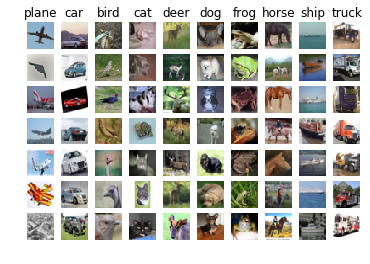

In [290]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [291]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [292]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


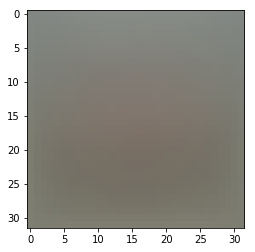

In [293]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [294]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [295]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) In KNN we did not subtract the mean from the data, or in other words we did not 'center' the data, since it works based on similarity definition using any of the norms (L1,L2,..). These norms are applied which work on vectors connecting data points in vector spaces. No matter whether we center our data or not, the distances (obtained from norms) in the vector space does not change. Hence, the result of the KNN will not be affected. At high level, centering the data does not change the distance-based similarity used for knn so we did not need to.

For SVM, on the other hand, centering the data will affect the results obtained for W matrix. We need to actually center the data since data belonging to different dimensions are dissimilar and SVM would favor the inputs that are "larger" and more far away from maximum-margin hyperplanes. In fact, there is not direct notion of relative distance of feature points, but rather distance to "optimal" hyperplaces are important.

## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [296]:
from nndl.svm import SVM

In [297]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])
print(svm.W.shape)

(10, 3073)


#### SVM loss

In [298]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

28739.84972087688
49000
The training set loss is 15569.977915410242.


#### SVM gradient

In [299]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = svm.loss_and_grad(X_dev,y_dev)
# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

48567.07743923132
500
48567.07829412234
500
numerical: -3.689838 analytic: -3.689838, relative error: 6.087010e-08
48567.077866676824
500
48567.077866676824
500
numerical: 3.165714 analytic: 3.165714, relative error: 1.905350e-08
48567.077584946215
500
48567.07814840744
500
numerical: -9.331309 analytic: -9.331309, relative error: 8.489963e-09
48567.077866676824
500
48567.077866676824
500
numerical: 11.571089 analytic: 11.571089, relative error: 1.882846e-08
48567.077581836624
500
48567.07815151703
500
numerical: -1.153990 analytic: -1.153991, relative error: 3.275240e-07
48567.07721458295
500
48567.0785187707
500
numerical: -4.315784 analytic: -4.315784, relative error: 7.170807e-09
48567.078503908255
500
48567.0772294454
500
numerical: -3.670100 analytic: -3.670099, relative error: 8.712966e-08
48567.07765864887
500
48567.07807470479
500
numerical: -12.606532 analytic: -12.606531, relative error: 1.200316e-08
48567.07736552907
500
48567.07836782458
500
numerical: -3.790232 analytic: 

## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [300]:
import time

In [301]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

Normal loss / grad_norm: 15966.609801313683 / 2149.29158910058 computed in 0.10100221633911133s
Vectorized loss / grad: 15966.609801313687 / 2149.2915891005805 computed in 0.007000923156738281s
difference in loss / grad: -3.637978807091713e-12 / 7.23372434858787e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 16557.38000190916
iteration 100 / 1500: loss 4701.089451272714
iteration 200 / 1500: loss 4017.3331379427877
iteration 300 / 1500: loss 3681.9226471953625
iteration 400 / 1500: loss 2732.6164373988995
iteration 500 / 1500: loss 2786.6378424645054
iteration 600 / 1500: loss 2837.0357842782673
iteration 700 / 1500: loss 2206.2348687399326
iteration 800 / 1500: loss 2269.03882411698
iteration 900 / 1500: loss 2543.23781538592
iteration 1000 / 1500: loss 2566.6921357268257
iteration 1100 / 1500: loss 2182.068905905164
iteration 1200 / 1500: loss 1861.118224425045
iteration 1300 / 1500: loss 1982.9013858528256
iteration 1400 / 1500: loss 1927.5204158582114
That took 8.729506254196167s


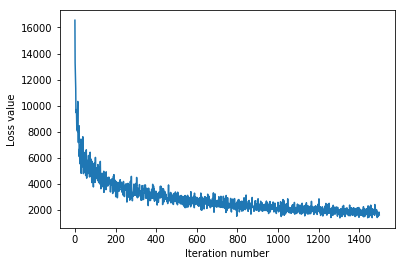

In [302]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [303]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))
y_test_pred = svm.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))


print('training error: {}'.format(1-np.mean(np.equal(y_train,y_train_pred), )))
print('validation errror: {}'.format(1-np.mean(np.equal(y_val, y_val_pred)), ))
print('test errror: {}'.format(1-np.mean(np.equal(y_test, y_test_pred)), ))



training accuracy: 0.28530612244897957
validation accuracy: 0.3
test accuracy: 0.248
training error: 0.7146938775510204
validation errror: 0.7
test errror: 0.752


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

Best Learning Rate:  0.025118864315095923
Best Validation Accuracy:  0.325
Best Validation Error:  0.675
Test Accuracy:  0.306
Test Error:  0.694


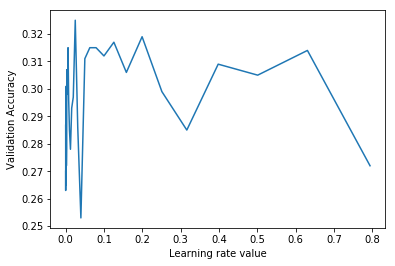

In [304]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #


Learning_rate = 10**np.arange(-4,0,0.1) 
#print(Learning_rate)
accuracy_test = []

for Lr in Learning_rate:
    loss_hist = svm.train(X_train, y_train, Lr, num_iters=1500, verbose=False)
    y_val_pred = svm.predict(X_val)
    accuracy_test.append(np.mean(np.equal(y_val, y_val_pred)))
    
Learning_rate_best_index = np.argmax(accuracy_test)
Learning_rate_best = Learning_rate[Learning_rate_best_index]

svm.train(X_train, y_train, Learning_rate_best, num_iters=1500, verbose=False)

y_est_test = svm.predict(X_test)
accuracy_test_f = np.mean(np.equal(y_test, y_est_test))

best_valication_accuracy =  1 - accuracy_test[Learning_rate_best_index]
error_test = 1 - accuracy_test_f

plt.figure()
plt.plot(Learning_rate, accuracy_test)
plt.xlabel('Learning rate value')
plt.ylabel('Validation Accuracy')

print('Best Learning Rate: ', Learning_rate_best)
print('Best Validation Accuracy: ', accuracy_test[Learning_rate_best_index])
print('Best Validation Error: ', best_valication_accuracy)
print('Test Accuracy: ', accuracy_test_f)
print('Test Error: ', error_test)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
